<a href="https://colab.research.google.com/github/ykitaguchi77/Strabismus_AI_project/blob/main/Hough_Mediapipe1.01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Hough変換を用いた虹彩検出**
https://ipsj.ixsq.nii.ac.jp/ej/?action=repository_action_common_download&item_id=113806&item_no=1&attribute_id=1&file_no=1<br>
※HEICファイルには未対応。https://www.apowersoft.jp/heic-to-jpgで先に変換。

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Google Mediapipe modules**

In [5]:
!pip install mediapipe

import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands


#サポートパッチのインポート
from google.colab.patches import cv2_imshow

#Face Mesh

#!/usr/bin/env python
# -*- coding: utf-8 -*-

import tensorflow as tf
import cv2 as cv
import numpy as np
import copy


class FaceMesh(object):
    def __init__(
        self,
        max_num_faces=1,
        min_detection_confidence=0.7,
        min_tracking_confidence=0.7,
    ):
        mp_face_mesh = mp.solutions.face_mesh
        self._face_mesh = mp_face_mesh.FaceMesh(
            max_num_faces=max_num_faces,
            min_detection_confidence=min_detection_confidence,
            min_tracking_confidence=min_tracking_confidence,
        )

    def __call__(
        self,
        image,
    ):
        # 推論
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        results = self._face_mesh.process(image)

        # X,Y座標を相対座標から絶対座標に変換
        # [X座標, Y座標, Z座標, Visibility, Presence]のリストに変更
        face_mesh_results = []
        if results.multi_face_landmarks is not None:
            for face_landmarks in results.multi_face_landmarks:
                face_mesh_results.append(
                    self._calc_landmarks(image, face_landmarks.landmark))
        return face_mesh_results

    def _calc_landmarks(self, image, landmarks):
        image_width, image_height = image.shape[1], image.shape[0]

        landmark_list = []
        for _, landmark in enumerate(landmarks):
            landmark_x = min(int(landmark.x * image_width), image_width - 1)
            landmark_y = min(int(landmark.y * image_height), image_height - 1)

            landmark_list.append((landmark_x, landmark_y, landmark.z,
                                  landmark.visibility, landmark.presence))
        return landmark_list

    def _calc_bounding_rect(self, landmarks):
        landmark_array = np.empty((0, 2), int)

        for _, landmark in enumerate(landmarks):
            landmark_x = int(landmark[0])
            landmark_y = int(landmark[1])

            landmark_point = [np.array((landmark_x, landmark_y))]
            landmark_array = np.append(landmark_array, landmark_point, axis=0)

        x, y, w, h = cv.boundingRect(landmark_array)

        return [x, y, x + w, y + h]

    def get_eye_landmarks(self, landmarks):
        # 目の輪郭の座標列を取得

        left_eye_landmarks = []
        right_eye_landmarks = []

        if len(landmarks) > 0:
            # 参考：https://github.com/tensorflow/tfjs-models/blob/master/facemesh/mesh_map.jpg
            # 左目
            left_eye_landmarks.append((landmarks[133][0], landmarks[133][1]))
            left_eye_landmarks.append((landmarks[173][0], landmarks[173][1]))
            left_eye_landmarks.append((landmarks[157][0], landmarks[157][1]))
            left_eye_landmarks.append((landmarks[158][0], landmarks[158][1]))
            left_eye_landmarks.append((landmarks[159][0], landmarks[159][1]))
            left_eye_landmarks.append((landmarks[160][0], landmarks[160][1]))
            left_eye_landmarks.append((landmarks[161][0], landmarks[161][1]))
            left_eye_landmarks.append((landmarks[246][0], landmarks[246][1]))
            left_eye_landmarks.append((landmarks[163][0], landmarks[163][1]))
            left_eye_landmarks.append((landmarks[144][0], landmarks[144][1]))
            left_eye_landmarks.append((landmarks[145][0], landmarks[145][1]))
            left_eye_landmarks.append((landmarks[153][0], landmarks[153][1]))
            left_eye_landmarks.append((landmarks[154][0], landmarks[154][1]))
            left_eye_landmarks.append((landmarks[155][0], landmarks[155][1]))

            # 右目
            right_eye_landmarks.append((landmarks[362][0], landmarks[362][1]))
            right_eye_landmarks.append((landmarks[398][0], landmarks[398][1]))
            right_eye_landmarks.append((landmarks[384][0], landmarks[384][1]))
            right_eye_landmarks.append((landmarks[385][0], landmarks[385][1]))
            right_eye_landmarks.append((landmarks[386][0], landmarks[386][1]))
            right_eye_landmarks.append((landmarks[387][0], landmarks[387][1]))
            right_eye_landmarks.append((landmarks[388][0], landmarks[388][1]))
            right_eye_landmarks.append((landmarks[466][0], landmarks[466][1]))
            right_eye_landmarks.append((landmarks[390][0], landmarks[390][1]))
            right_eye_landmarks.append((landmarks[373][0], landmarks[373][1]))
            right_eye_landmarks.append((landmarks[374][0], landmarks[374][1]))
            right_eye_landmarks.append((landmarks[380][0], landmarks[380][1]))
            right_eye_landmarks.append((landmarks[381][0], landmarks[381][1]))
            right_eye_landmarks.append((landmarks[382][0], landmarks[382][1]))

        return left_eye_landmarks, right_eye_landmarks

    def calc_eye_bbox(self, landmarks):
        # 目に隣接するバウンディングボックスを取得

        left_eye_lm, right_eye_lm = self.get_eye_landmarks(landmarks)

        left_eye_bbox = self._calc_bounding_rect(left_eye_lm)
        right_eye_bbox = self._calc_bounding_rect(right_eye_lm)

        return left_eye_bbox, right_eye_bbox

    def calc_around_eye_bbox(self, landmarks, around_ratio=0.5):
        # 目の周囲のバウンディングボックスを取得

        left_eye_bbox, right_eye_bbox = self.calc_eye_bbox(landmarks)

        left_eye_bbox = self._calc_around_eye(left_eye_bbox, around_ratio)
        right_eye_bbox = self._calc_around_eye(right_eye_bbox, around_ratio)

        return left_eye_bbox, right_eye_bbox

    def _calc_around_eye(self, bbox, around_ratio=0.5):
        x1, y1, x2, y2 = bbox
        x = x1
        y = y1
        w = x2 - x1
        h = y2 - y1

        cx = int(x + (w / 2))
        cy = int(y + (h / 2))
        square_length = max(w, h)
        x = int(cx - (square_length / 2))
        y = int(cy - (square_length / 2))
        w = square_length
        h = square_length

        around_ratio = 0.5
        x = int(x - (square_length * around_ratio))
        y = int(y - (square_length * around_ratio))
        w = int(square_length * (1 + (around_ratio * 2)))
        h = int(square_length * (1 + (around_ratio * 2)))

        return [x, y, x + w, y + h]




#iris landmark

#!/usr/bin/env python
# -*- coding: utf-8 -*-

class IrisLandmark(object):
    def __init__(
        self,
        model_path='/content/drive/MyDrive/Deep_learning/iris_landmark.tflite',
        num_threads=1,
    ):
        self._interpreter = tf.lite.Interpreter(model_path=model_path,
                                                num_threads=num_threads)
        self._interpreter.allocate_tensors()
        self._input_details = self._interpreter.get_input_details()
        self._output_details = self._interpreter.get_output_details()

    def __call__(
        self,
        image,
    ):
        input_shape = self._input_details[0]['shape']

        # 正規化・リサイズ
        img = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        img = img / 255.0
        img_resized = tf.image.resize(img, [input_shape[1], input_shape[2]],
                                      method='bicubic',
                                      preserve_aspect_ratio=False)
        img_input = img_resized.numpy()
        img_input = (img_input - 0.5) / 0.5

        reshape_img = img_input.reshape(1, input_shape[1], input_shape[2],
                                        input_shape[3])
        tensor = tf.convert_to_tensor(reshape_img, dtype=tf.float32)

        # 推論実行
        input_details_tensor_index = self._input_details[0]['index']
        self._interpreter.set_tensor(input_details_tensor_index, tensor)
        self._interpreter.invoke()

        # 推論結果取得
        output_details_tensor_index0 = self._output_details[0]['index']
        output_details_tensor_index1 = self._output_details[1]['index']
        eye_contour = self._interpreter.get_tensor(
            output_details_tensor_index0)
        iris = self._interpreter.get_tensor(output_details_tensor_index1)

        return np.squeeze(eye_contour), np.squeeze(iris)

    def get_input_shape(self):
        input_shape = self._input_details[0]['shape']
        return [input_shape[1], input_shape[2]]



#Module

def detect_iris(image, iris_detector, left_eye, right_eye):
    image_width, image_height = image.shape[1], image.shape[0]
    input_shape = iris_detector.get_input_shape()

    # 左目
    # 目の周辺の画像を切り抜き
    left_eye_x1 = max(left_eye[0], 0)
    left_eye_y1 = max(left_eye[1], 0)
    left_eye_x2 = min(left_eye[2], image_width)
    left_eye_y2 = min(left_eye[3], image_height)
    left_eye_image = copy.deepcopy(image[left_eye_y1:left_eye_y2,
                                         left_eye_x1:left_eye_x2])
    # 虹彩検出
    eye_contour, iris = iris_detector(left_eye_image)
    # 座標を相対座標から絶対座標に変換
    left_iris = calc_iris_point(left_eye, eye_contour, iris, input_shape)

    # 右目
    # 目の周辺の画像を切り抜き
    right_eye_x1 = max(right_eye[0], 0)
    right_eye_y1 = max(right_eye[1], 0)
    right_eye_x2 = min(right_eye[2], image_width)
    right_eye_y2 = min(right_eye[3], image_height)
    right_eye_image = copy.deepcopy(image[right_eye_y1:right_eye_y2,
                                          right_eye_x1:right_eye_x2])
    # 虹彩検出
    eye_contour, iris = iris_detector(right_eye_image)
    # 座標を相対座標から絶対座標に変換
    right_iris = calc_iris_point(right_eye, eye_contour, iris, input_shape)

    return left_iris, right_iris


def calc_iris_point(eye_bbox, eye_contour, iris, input_shape):
    iris_list = []
    for index in range(5):
        point_x = int(iris[index * 3] *
                      ((eye_bbox[2] - eye_bbox[0]) / input_shape[0]))
        point_y = int(iris[index * 3 + 1] *
                      ((eye_bbox[3] - eye_bbox[1]) / input_shape[1]))
        point_x += eye_bbox[0]
        point_y += eye_bbox[1]

        iris_list.append((point_x, point_y))

    return iris_list


def calc_min_enc_losingCircle(landmark_list):
    center, radius = cv.minEnclosingCircle(np.array(landmark_list))
    center = (int(center[0]), int(center[1]))
    radius = int(radius)

    return center, radius


def draw_debug_image(
    debug_image,
    left_iris,
    right_iris,
    left_center,
    left_radius,
    right_center,
    right_radius,
):
    # 虹彩：外接円
    cv.circle(debug_image, left_center, left_radius, (0, 255, 0), 2)
    cv.circle(debug_image, right_center, right_radius, (0, 255, 0), 2)

    # 虹彩：ランドマーク
    for point in left_iris:
        cv.circle(debug_image, (point[0], point[1]), 1, (0, 0, 255), 1)
    for point in right_iris:
        cv.circle(debug_image, (point[0], point[1]), 1, (0, 0, 255), 1)

    # 虹彩：半径
    cv.putText(debug_image, 'r:' + str(left_radius) + 'px',
               (left_center[0] + int(left_radius * 1.5),
                left_center[1] + int(left_radius * 0.5)),
               cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 1)
    cv.putText(debug_image, 'l:' + str(right_radius) + 'px',
               (right_center[0] + int(right_radius * 1.5),
                right_center[1] + int(right_radius * 0.5)),
               cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 1)

    return debug_image

     |████████████████████████████████| 32.4 MB 113 kB/s 


#**Hough変換を用いた角膜反射と虹彩のセグメンテーション**

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import hough_circle, hough_circle_peaks, hough_ellipse
from skimage.feature import canny
from skimage.draw import circle_perimeter, ellipse_perimeter
from skimage.color import rgb2gray
from skimage import data, color, img_as_ubyte
import matplotlib.patches as patches
import dlib


def hough_segmentation(center, radius, image):
    #眼周囲の画像を切り抜き

    x0 = center[0]-left_radius*2
    x1 = center[0]+left_radius*2
    y0 = center[1]-left_radius*2
    y1 = left_center[1]+left_radius*2

    img3 = image[y0 : y1, x0 : x1]
    cv2_imshow(img3)

    #白黒化
    gray = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
    #cv2_imshow(gray)


    #OTSUの2値化
    ret, th = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    cv2_imshow(th)

    #Canny法によるedge検出
    edges = canny(th)
    fig, ax = plt.subplots()
    ax.imshow(edges, cmap=plt.cm.gray)

    #ハフ変換による円検出
    min_radius = int(left_radius*0.8)
    max_radius = int(left_radius*1.5)

    hough_radii = np.arange(min_radius, max_radius, 1)
    hough_res = hough_circle(edges, hough_radii)
    hough_res.shape
    #(4, 400, 400)

    #誤差が少なく近似されている円の選出
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                              total_num_peaks=1) #数字を増やすと検出する円の種類を増やせる
    #print(accums)
    #print(cx)
    #print(cy)
    #print(radii)


    #結果の表示
    fig, ax = plt.subplots()

    # Draw the most prominent 1 circles
    image_cornea = color.gray2rgb(img3)
    for center_y, center_x, radius in zip(cy, cx, radii):
        circy, circx = circle_perimeter(center_y, center_x, radius,
                                        shape=image.shape)
        image_cornea[circy, circx] = (220, 20, 20)

    ax.imshow(image_cornea, cmap=plt.cm.gray)
    plt.show()



    #ここから角膜反射検出

    h, w = img3.shape[:2]
    #print(h)
    #print(w)
    print("center_y: "+str(center_y))
    print("center_x: "+str(center_x))
    print("radius: "+str(radius))

    # 検出した虹彩に沿ったマスク作成 (黒く塗りつぶす画素の値は0)
    mask = np.zeros((h, w), dtype=np.uint8)
    # 円を描画する関数 circle() を利用してマスクの残したい部分を 255 にしている。
    cv2.circle(mask, center=(center_x, center_y), radius=radius, color=255, thickness=-1)

    # マスクを描画
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    #plt.show()

    img4 = copy.deepcopy(img3)
    img4[mask==0] = [0, 0, 0]  # mask の値が 0 の画素は黒で塗りつぶす。
    plt.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


    # 画像の白いところを抜き出す
    hsv = cv2.cvtColor(img4, cv2.COLOR_BGR2HSV)

    lower_white = np.array([0,0,200])
    upper_white = np.array([180,45,255])

    mask_white = cv2.inRange(hsv, lower_white, upper_white)
    res_white = cv2.bitwise_and(img4, img4, mask= mask_white)

    plt.imshow(res_white)
    plt.axis('off')
    plt.show()


    #RGBに直す
    res_white_WB = cv2.cvtColor(res_white, cv2.COLOR_BGR2GRAY)

    #輪郭検出
    contours, hierarchy = cv2.findContours(
        res_white_WB, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # 小さい輪郭は誤検出として削除する
    contours = list(filter(lambda x: cv2.contourArea(x) > 1, contours))

    #輪郭の重心を計算(検出されたすべての輪郭に対して)
    candidate = center_of_gravity(contours)

    #画像の中心（横幅の中心、縦幅の上3/10）に近いものを選択する
    #※上1/3にしているのは、MRD-1<MRD-2であるため
    img_center = [int(0.5*img4.shape[0]), int(0.3*img4.shape[1])]
    print("img_center: "+str(img_center))

    pupil_center = nearPoint(candidate, img_center)

    print("nearest from the center: "+str(pupil_center))

    img5 = copy.deepcopy(img3)
    img5_rgb = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
    cv2.circle(img5_rgb, (pupil_center[0], pupil_center[1]), 2, (255,0,0), 2, 4)
    plt.imshow(img5_rgb)
    plt.show()

    print("Center of cornea: ["+str(int(cx))+", "+str(int(cy))+"]" )
    print("Corneal reflex: ["+str(pupil_center[0])+", "+str(pupil_center[1])+"]" )

    return int(cx), int(cy), radius, pupil_center[0], pupil_center[1]



def center_of_gravity(contours):
    coordinate = []
    k=0
    for c in contours:
        mu = cv2.moments(c)
        coordinate.append([int(mu["m10"]/mu["m00"]), int(mu["m01"]/mu["m00"])])
        print("candidate"+str(k)+": "+str(coordinate[k]))
        k+=1
    return coordinate


def nearPoint(coordinates, point):
    pupil_coordinate = [0,0]
    result = 10000000
    for i in coordinates:
        distance = int((i[0]-point[0])**2 + (i[1]-point[1])**2)
        #print(distance)
        if distance < result:
            result = distance
            pupil_coordinate[0] = i[0]
            pupil_coordinate[1] = i[1]
    return pupil_coordinate


def mediapipe_iris(face_results, image):
    for face_result in face_results:
    # 目周辺のバウンディングボックス計算
        left_eye, right_eye = face_mesh.calc_around_eye_bbox(face_result)

        # 虹彩検出
        left_iris, right_iris = detect_iris(image, iris_detector, left_eye,
                                            right_eye)

        # 虹彩の外接円を計算
        left_center, left_radius = calc_min_enc_losingCircle(left_iris)
        right_center, right_radius = calc_min_enc_losingCircle(right_iris)

        """
        # デバッグ描画
        debug_image = copy.deepcopy(image)
        debug_image = draw_debug_image(
            debug_image,
            left_iris,
            right_iris,
            left_center,
            left_radius,
            right_center,
            right_radius,
         )
         """
    return right_center, right_radius, left_center, left_radius


def dlib_iris(image):
    predictor_path = '/content/drive/My Drive/AI_laboratory_course/shape_predictor_68_face_landmarks.dat'
    predictor = dlib.shape_predictor(predictor_path)
    detector = dlib.get_frontal_face_detector()

    rects = detector(image, 1)
    if len(rects) == 0:
        print('顔が抽出されませんでした')
        exit()

    """
    for rect in rects:
        for idx,p in enumerate(predictor(image,rect).parts()): 
            x = p.x
            y = p.y
            cv2.circle(image, (x,y),2, (0,255,0), thickness= 3)
            cv2.putText(image,str(idx) , (x + 3, y+3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), thickness=1)
    
    cv2_imshow(image)
    """

    dets = detector(image[:, :, ::-1])
    parts = predictor (image, dets[0]).parts()

    right_center = [int((parts[37].x+parts[43].x)/2), int((parts[37].y+parts[38].y)/2)]
    right_radius = int((parts[38].x-parts[37].x)/2)
    left_center = [int((parts[43].x+parts[44].x)/2), int((parts[43].y+parts[47].y)/2)]
    left_radius = int((parts[44].x-parts[43].x)/2)

    return right_center, right_radius, left_center, left_radius



#**Google Mediapipeを用いて大まかな虹彩の位置を検出する**

In [12]:

img_path = "/content/drive/MyDrive/Deep_learning/eyelid_images/in/100/20100811101531_眼位_O_0_b1becf0e5c9818fbc1740320491c79c7db62b2eccc74d8bda21920580d40ff66.jpg"
print(img_path)

/content/drive/MyDrive/Deep_learning/eyelid_images/in/100/20100811101531_眼位_O_0_b1becf0e5c9818fbc1740320491c79c7db62b2eccc74d8bda21920580d40ff66.jpg


[2093, 1377]
32
[1854, 1337]
32


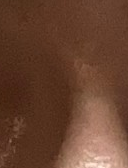

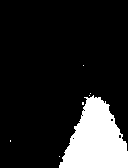

IndexError: ignored

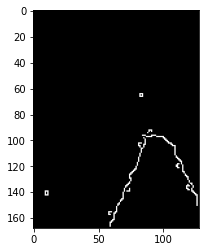

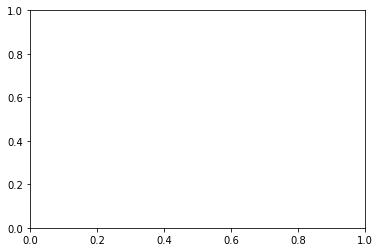

In [15]:
# For static images:

img_path = "/content/drive/MyDrive/Deep_learning/Face_Images/IMG_3990.JPG"
image = cv2.imread(img_path)
#cv2_imshow(image)


# 引数 #####################################################################

max_num_faces = 1
min_detection_confidence = 0.7
min_tracking_confidence = 0.7


# モデルロード #############################################################
face_mesh = FaceMesh(
    max_num_faces,
    min_detection_confidence,
    min_tracking_confidence,
)
iris_detector = IrisLandmark()

# 検出実施 #############################################################
# Face Mesh検出
face_results = face_mesh(image)


if face_results is []:
    right_center, right_radius, left_center, left_radius = mediapipe_iris(face_results, image)

else:
    right_center, right_radius, left_center, left_radius =  dlib_iris(image)

print(left_center)
print(left_radius)
print(right_center)
print(right_radius)

#cv2_imshow(debug_image)
cv.destroyAllWindows()


cx, cy, rad, lx, ly = hough_segmentation(right_center, right_radius, image)
right_radius = rad
right_center = [cx - right_radius*1.5 + right_center[0], cy - right_radius*1.5 + right_center[1]]
right_reflex = [lx - right_radius*1.5 + right_center[0], ly - right_radius*1.5 + right_center[1]]

print(right_radius)
print(right_center)
print(right_reflex)